# Utilities:

Progress bar to keep track of actions like image and label import

In [1]:
# Print progress
def print_progress (iteration, total, message = '', length = 20):
    
    # Calculate percent complete
    percent = "{0:.1f}".format(iteration / total * 100)
    # Determine fill of loading bar, length is the total length
    fill = int(length * iteration / total)
    # Determine the empty space of the loading bar
    empty = ' ' * (length - fill)
    # Animate the bar with unicode character 2588, a filled block
    bar = u"\u2588" * fill + empty
    
    # Print loading bar
    print(f'\r{message} |{bar}| {percent}% ', end = '\r')
   
    # Print new line on completion
    if iteration == total: 
        print()

In [2]:
import time

for i in range(250):
    time.sleep(0.01)
    print_progress(i,250-1,message='Loading images: ')
    
for i in range(100):
    time.sleep(0.01)
    print_progress(i,100-1,message='Loading labels: ')

Loading images:  |████████████████████| 100.0% 
Loading labels:  |████████████████████| 100.0% 


# Task A
## Image and label data import

Loading images from source folders using homemade modules.

/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments
Importing image data...
Image data is stored in numpy array 'X' of size: (5000, 218, 178, 3)
Importing labels...
Label data is stored in Pandas DataFrame 'y' with dimensions: (5000, 4)
Displaying random images and corresponding labels from set...


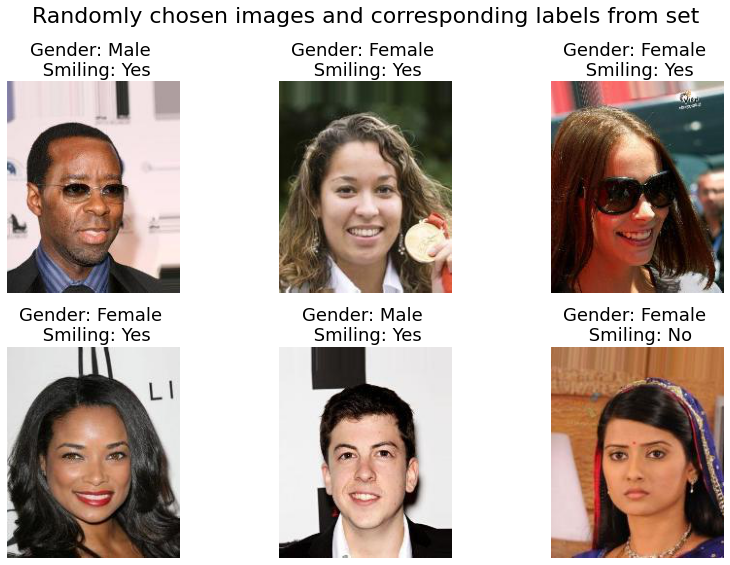

In [3]:
# To modularise the program, we need to add the current directory to sys path
import os
import sys

# Grab the current file path...
currentPath = os.path.dirname(os.path.abspath(os.getcwd()))

print(currentPath)

# ... and append it to the system path
sys.path.append(currentPath)

# Now we can import our own modules into our script.
import Final.code.import_data as ds
import Final.code.split_dataset as sd 

# numpy for enhanced mathematical support
import numpy as np
# Matplotlib for visualisation
import matplotlib.pyplot as plt

# Define a path to the data - REMEMBER TO RESET THIS BEFORE TURNING IN
img_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/img/"
label_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/"

# Load image and label data with the novel 'import_data' module
X , y , random_img = ds.dataImport(img_path,label_path,surpress=False,return_img_indices=True)

## Split into testing, validation and training sets

Plotting the dataset split...


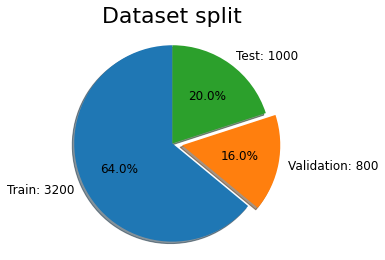

In [4]:
# Split data to train, validation and test sets
Xtrain,Xtest,Xval,ytrain,ytest,yval = sd.split_dataset(X,y,
                                                       test_size=0.2,
                                                       val_size=0.2,
                                                       surpress=False) 

## Task A1
### Classify images on 'gender'

# Pre-process images

We've got a couple of ways of converting the images to grayscale - here I'm comparing how the results vary visually from calculating the mean, $\mu$, over the three `RGB` channels, with *de facto* encoding methods such as Rec 601 (ITU-R Recommendation BT.601) which uses the weights:<br> 
`R ~ 0.3 | G ~ 0.6 | B ~ 0.15`<br>
to flatten the color channels.

In [5]:
# Task A1 determine gender
ytrain_A1 = ytrain.loc[:,'gender']
print(ytrain_A1.shape)
XmeanRGB = Xtrain.mean(axis=3)
print(XmeanRGB.shape)

(3200,)
(3200, 218, 178)


In [6]:
RGB_weights = [0.2989, 0.5870, 0.1140]
XweightRGB = np.dot(Xtrain[...,:3], RGB_weights)

Let me check what the maximum value difference between Weighted and Mean RGB is across all the images:

In [7]:
pixelDiff = XmeanRGB - XweightRGB

In [8]:
print("Highest deviation between the two encoding methods for any individual pixel found to be: {:.2f}".format(pixelDiff.max()))
print("Found at: {}".format(np.where(pixelDiff==pixelDiff.max())))

Highest deviation between the two encoding methods for any individual pixel found to be: 55.73
Found at: (array([3027, 3027, 3027, 3027, 3027, 3027]), array([149, 150, 151, 152, 153, 154]), array([0, 0, 0, 0, 0, 0]))


(-0.5, 177.5, 217.5, -0.5)

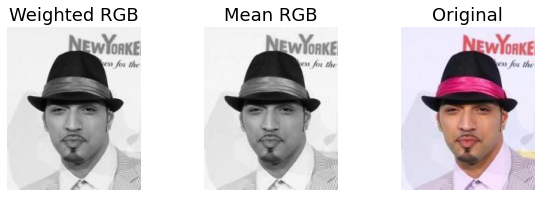

In [9]:
sample = 2516

fig,ax=plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(XweightRGB[sample,...],cmap=plt.get_cmap("gray"))
ax[0].set_title("Weighted RGB")
ax[0].axis("off")
ax[1].imshow(XmeanRGB[sample,...],cmap=plt.get_cmap("gray"))
ax[1].set_title("Mean RGB")
ax[1].axis("off")
ax[2].imshow(Xtrain[sample,...],cmap=plt.get_cmap("gray"))
ax[2].set_title("Original")
ax[2].axis("off")

### Conclusion?

To be frank I don't see too big of a difference between the two methods. It seems there may be a slightly different shade of gray converting certain vibrant colours like purple, likely due to the decreased weights that the `R-B` channels are given. <br>
However there is one important aspect to note here, and it is that the `rgb_weights` key gives us a way to decode the encoded grayscale image back to the `RGB` plane, hence we will chose to use weighted RGB.

## Flatten images for PCA

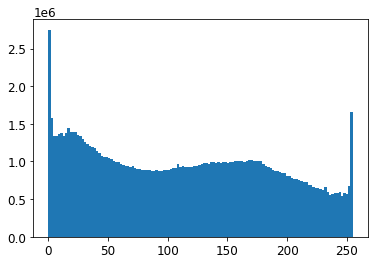

In [10]:
plt.figure()
plt.hist(XweightRGB.flatten(),128)
plt.show()

In [11]:
x,y,z = XweightRGB.shape # Xmean is a three dimensional array
Xtrain_A1 = np.reshape(XweightRGB, (x,y*z)) # We want to reshape it by folding the 2nd and 3rd dimensions, i.e. y,z
print(Xtrain_A1.shape)  # It will output a shape (3200, 38804)

(3200, 38804)


Figure out the mean of the data

In [12]:
Xmean = XweightRGB.mean(axis=0)

Visualise it

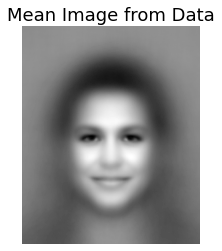

In [13]:
plt.figure()
plt.imshow(Xmean,cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.title("Mean Image from Data")
plt.show()

So our PCA will represent a deviation from this lovely... lady?

That makes me wonder how the data is split with regards to Male / Female samples

In [14]:
# I'll leave this cell here if I wish to check that out later

Center images:

In [15]:
# Let's flatten the mean image from 218 x 178 to 1 x 38804:
Xmean = Xmean.flatten()

# Let's load the centered images to a list using a comprehension
Xcenter = np.array([Xtrain_A1[img,...] - Xmean for img in range(len(Xtrain_A1))])

Check size....

In [16]:
Xcenter.shape

(3200, 38804)

Visualise one sample in the name of science

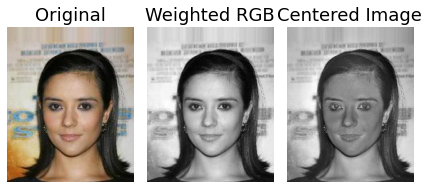

In [173]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(Xtrain[1])
ax[0].axis("off")
ax[0].set_title("Original")
ax[1].imshow(XweightRGB[1].reshape(218,178),cmap=plt.get_cmap("gray"))
ax[1].axis("off")
ax[1].set_title("Weighted RGB")
ax[2].imshow(Xcenter[1].reshape(218,178),cmap=plt.get_cmap("gray"))
ax[2].axis("off")
ax[2].set_title("Centered Image")
plt.tight_layout()
plt.show()

# PCA for dimensionality reduction using SVD

Here we perform principal component analysis on our centered imageset.
We use singular value decomposition

In [184]:
U, Sigma, WT = np.linalg.svd(Xcenter, full_matrices=False)

In [185]:
# Check dimensions
print("Centered data to process X:", Xcenter.shape)
print("Covariance Matrix U:", U.shape)
print("Eigenvalues Sigma:", Sigma.shape)
print("Eigenvectors WT:", WT.shape)

Centered data to process X: (3200, 38804)
Covariance Matrix U: (3200, 3200)
Eigenvalues Sigma: (3200,)
Eigenvectors WT: (3200, 38804)


In [186]:
X_dim_red = WT[:,:100]
X_dim_red.shape

(3200, 100)

## Scree plot
How many features do we really need to accurately describe our imaged data?<br>
This PCA Scree Plot may help us decide.

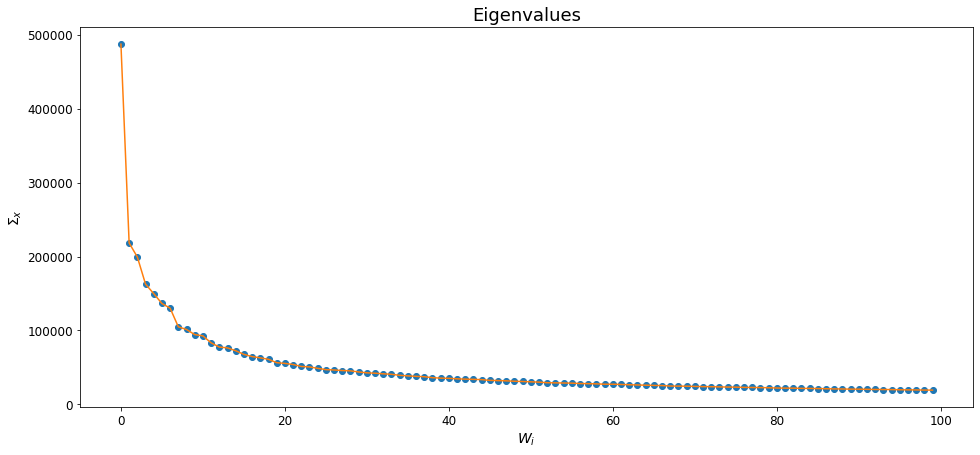

In [189]:
features = 100
plt.figure(figsize=(16,7))
plt.plot(range(features),Sigma[:features],'o')
plt.plot(range(features),Sigma[:features])
plt.xlabel("$W_i$")
plt.ylabel("$\Sigma_{x}$")
plt.title("Eigenvalues")
plt.show()

I get a feeling that anything in between 20 and 40 eigenvectors, i.e. features will do.<br>
This means we have reduced our feature vector from:

\begin{equation}
X = X_{218 \times 178 px} = x_{1. px},x_{2. px} ... x_{38,804. px}
\end{equation}

Where each pixel, $px$, corresponds to a feature, to:

\begin{equation}
X = x_{W_{1}}...x_{W_{30}}
\end{equation}

Where $W_{i}$ are the image's eigenvectors.
The scree plot, where we plot eigenvalues against the 1st, 2nd, etc. eigenvectors displays how much information is carried in every $i$-th dimension. We see somewhat a convergence at $W_{i=20}$, which indicates that only about the 20 first factors can be interpreted as statistically significant.

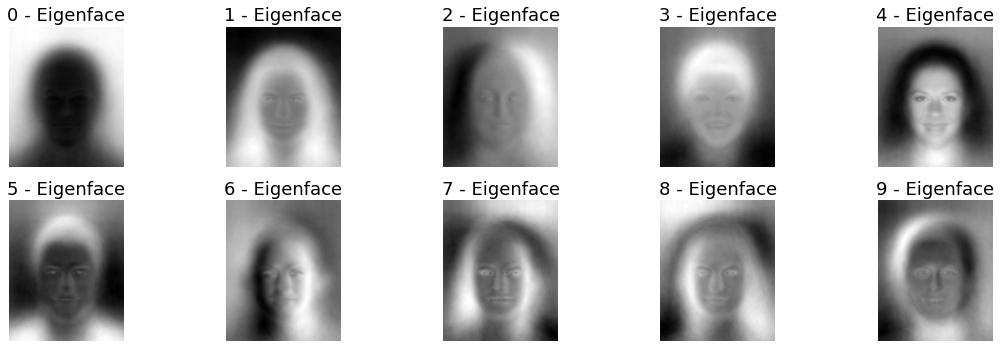

In [190]:
fig,ax = plt.subplots(2,5,figsize=(16,5))
row,col = ax.shape

k = 0

for i in range(row):
    for j in range(col):
        ax[i,j].imshow(np.reshape(WT[k,:], (218,178)),cmap=plt.get_cmap("gray"))
        ax[i,j].axis("off")
        ax[i,j].set_title("{} - Eigenface".format(k))
        k+=1
        
plt.tight_layout()
plt.show()

Calculate the covariance matrix